# Example implementation of pure differential privacy

By [Armaan Bhojwani](https://armaanb.net) under [Praneeth Vepakomma](https://praneeth.mit.edu/)

Privatizing the height data of a class using the laplace mechanism.

In this notebook we do the following:
1. Define parameters with which to operate
1. Generate a dataset to work on
1. Implement functions that return differentially private versions of sum, count, and mean
1. Clip for sensitivity
1. Analyze the accuracy of the private mean across various epsilons

### Dependencies
- matplotlib
- scipy
- tqdm

### Status
- Complete
- Could make the clipping process epsilon-delta DP

## Parameters

### Data parameters

For our data, we will draw `num_records` number of samples from a gaussian distribution with parameters `height_loc` and `height_std` for mean and standard deviation respectively. This should create a distribution of heights fairly accurate to what you might find in the real world. The default values of 175 and 7 for the height distribution parameters are accurate for the US in centimeters.

In [1]:
num_records = 8000  # Number of records to create
height_loc = 175    # Mean of height distribution (175 is USA mean)
height_std = 7      # Standard deviation of height distributlon (7 is USA std)

### Analysis parameters
The `max_epsilon` and `epsilon_step` parameters are used to create a list of epsilons which we will use to show how the efficacy of DP changes with varying epsilon.

`num_samples` is the number of times to run these tests. Higher is better, but will take longer.

In [2]:
max_epsilon = 10     # Largest epsilon value to test
epsilon_step = 0.25  # Step size between epsilons
# With these parameters, we test epsilons [0.25, 0.5... 9.75, 10]

num_samples = 20000  # Number of times to run lim x->inf functions

### Clipping parameters

Reccomended reading: https://programming-dp.com/ch5.html#clipping

These parameters configure the process for clipping for the bounds of the `sum` function sensitivity. The `max_height` parameter is the upper bound for calculating the clipping of the sensitivity of the sum query. It should be higher than any expected height in the distribution, but not so high as to waste computational power. `clipping_epsilon` is the epsilon value used when adding noise during the clipping process. With small datasets, epsilon should be high so that the scale of the noise does not overcome the scale of the data. For larger datasets, the `clipping_epsilon` can be more reasonable. `smoothing_width` and `slope_width` determine how much smoothing to do during the smoothing and slope steps respectively. Lower epsilons can allow for lower `smoothing_width` and `slope_width`. `growth_bound` is the value at which growth in the cumulative sum can be considered negligible.

In [3]:
max_height = 250      # Clipping bound greater than any height in the dataset
clipping_epsilon = 3  # Epsilon to use when calculating clipping bound
smoothing_width = 15  # Width of window to use for initial smoothing
slope_width = 10      # Width of window to use when calculating rolling slope
growth_bound = 0.25   # Slope at which to consider change negligible

## Building the data


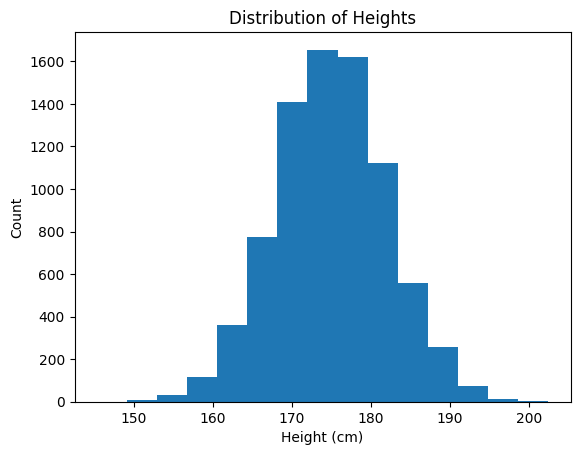

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Create height distribution and draw from it to create our height data
rng = np.random.default_rng()
heights = rng.normal(loc=height_loc, scale=height_std, size=num_records)
heights = np.asarray([round(height, 2) for height in heights])

# Plot
plt.title("Distribution of Heights")
plt.xlabel("Height (cm)")
plt.ylabel("Count")
plt.hist(heights, bins=15)
plt.show()

## Differential Privacy
### Laplace noise functions

Implementations of adding laplace noise to given functions.

In [5]:
def laplace_mech(epsilon, sensitivity):
    """ Sample adequate laplace noise
    Inputs:
        epsilon: epsilon value to use
        sensitivity: sensitivity to use
    
    Output:
        Laplace noise given the parameters
    """
    return rng.laplace(scale=sensitivity / epsilon)


def dp_sum(data, epsilon, sensitivity):
    """ Differentially private sum
    Inputs:
        data: array of numbers to sum
        epsilon: epsilon value to use
        sensitivity: sensitivity to use.

    Output:
        Non private sum + appropriate laplace noise
    """
    return np.sum(data) + laplace_mech(epsilon, sensitivity)


def dp_count(data, epsilon):
    """ Differentially private count
    Inputs:
        data: array of numbers to sum
        epsilon: epsilon value to use

    Output:
        Non private count + appropriate laplace noise
    """
    sensitivity = 1
    return np.size(data) + laplace_mech(epsilon, sensitivity)


def dp_mean(data, epsilon, sum_sensitivity=0):
    """ Differentially private mean utilizing dp_sum and dp_count functions
    Inputs:
        data: array of numbers to sum
        epsilon: epsilon value to use
        sum_sensitivity: sensitivity to use for the sum query
            Defaults to the maximum value in the dataset

    Output:
        Differentially private mean
    """
    return dp_sum(data, epsilon, sum_sensitivity) / dp_count(data, epsilon)

### Clipping
See https://programming-dp.com/ch5.html#clipping and the documentation in the parameters section

#### Step 1

In [6]:
from tqdm.notebook import tqdm


def clipping_step1(heights, clipping_epsilon, max_height):
    """ Step 1 of the clipping process
            Calculates privacy cumulative sums of the data
    Inputs:
        heights: height data
        clipping_epsilon: epsilon to use in clipping
        max_height: value to stop testing at

    Output:
        Array of cumulative sums with laplace noise
    """
    epsilon_i = clipping_epsilon / max_height
    data1 = [
        heights.clip(min=0, max=i).sum() + laplace_mech(epsilon_i, i)
        for i in range(max_height)
    ]

    return data1


data1 = clipping_step1(heights, clipping_epsilon, max_height)

#### Step 2

In [7]:
def clipping_step2(data1, smoothing_width):
    """ Step 2 of the clipping process
            Smooths the data gathered in step 1
    Inputs:
        data1: data collected in step 1
        smoothing_width: width of the window to smooth over

    Output:
        Smoothed version of data from step1
    """
    cumsum_vec = np.cumsum(np.insert(data1, 0, 0))
    data2 = (cumsum_vec[smoothing_width:] -
             cumsum_vec[:-smoothing_width]) / smoothing_width

    return data2


data2 = clipping_step2(data1, smoothing_width)

#### Step 3

In [8]:
from scipy.stats import linregress


def clipping_step3(data2, slope_width, growth_bound):
    """ Step 3 of the clipping process
            Calculates the rate of change over a rolling window of data
            gathered in step 2
    Inputs:
        data2: data collected in step 2
        slope_width: width of the window over which to calculate the slope
        growth_bound: slope at which to consider growth negligible

    Output:
        Derivative of step 2, differentially private sensitivity to use
    """
    # Calculate maximum slope between heights
    deviations = np.diff(data2)
    print(max(deviations))

    data3 = []
    for i in range(slope_width, len(data2) - slope_width + 1):
        area = range(i - slope_width, i + slope_width)
        data3.append(linregress(area, [data2[i] for i in area])[0])

    data3 = np.asarray(data3)
    upper_bound = np.where(data3 <= growth_bound)[0][0]

    return data3, upper_bound


data3, sum_sensitivity = clipping_step3(data2, slope_width, growth_bound)

10449.964151012013


#### Plotting

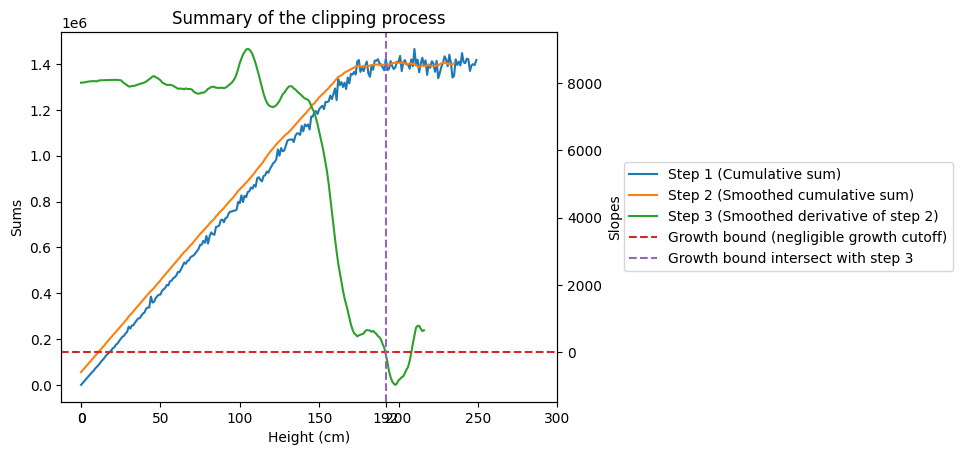

In [9]:
fig, ax1 = plt.subplots()

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.title("Summary of the clipping process")
plt.xlabel("Height (cm)")

# Axis 1
plt.ylabel("Sums")
plt.plot(data1, label="Step 1 (Cumulative sum)")
plt.plot(data2, label="Step 2 (Smoothed cumulative sum)")

# Axis 2
ax2 = ax1.twinx()
plt.ylabel("Slopes")

plt.plot(data3,
         label="Step 3 (Smoothed derivative of step 2)",
         color=colors[2])
plt.axhline(growth_bound,
            linestyle="dashed",
            label="Growth bound (negligible growth cutoff)",
            color=colors[3])

# Intersect
plt.axvline(sum_sensitivity,
            linestyle="dashed",
            label="Growth bound intersect with step 3",
            color=colors[4])
plt.xticks(np.append(ax2.get_xticks(), sum_sensitivity).clip(min=0))

# Legend
handles, labels = [], []
for ax in fig.axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1.12, 0.5))

plt.show()

### Analysis of mean

Find the mean height at various epsilons given the parameters above and record the data.

In [10]:
from common import get_epsilons

epsilons = get_epsilons(max_epsilon, epsilon_step)

# Iterate through each epsilon value and take the mean num_samples times over
data = []
range_data = []
for epsilon in tqdm(epsilons):
    epsilon_data = []
    for i in range(num_samples):
        epsilon_data.append(dp_mean(heights, epsilon, sum_sensitivity))

    range_data.append(max(epsilon_data) - min(epsilon_data))
    data.append(epsilon_data)

  0%|          | 0/39 [00:00<?, ?it/s]

#### Plotting

Plot the possible values of the differentially private results for each epsilon tested.

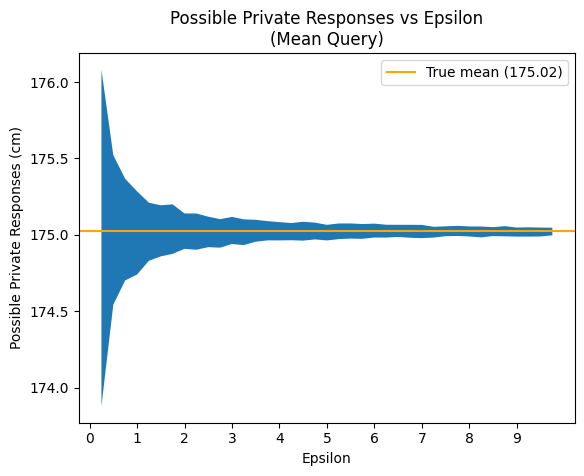

In [11]:
dp_height_mean_maxes = [np.max(i) for i in data]
dp_height_mean_mins = [np.min(i) for i in data]

fig, ax = plt.subplots()
ax.fill_between(epsilons, dp_height_mean_maxes, dp_height_mean_mins)

heights_mean = np.mean(heights)
plt.axhline(heights_mean,
            color="orange",
            label=f"True mean ({round(heights_mean, 2)})")

plt.xticks(np.arange(max(epsilons)))
plt.title("Possible Private Responses vs Epsilon\n(Mean Query)")
plt.xlabel("Epsilon")
plt.ylabel("Possible Private Responses (cm)")
ax.legend()
plt.show()

From this data, we can see that you start to get diminishing returns around an epsilon of 5, thus for good privacy you should select an epsilon value lower than that.

### Plot range data

Plot the range of the DP results found, and their difference from the true (non-private) mean.

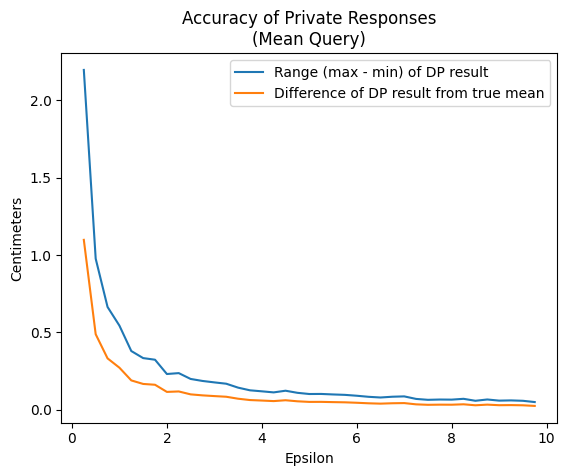

In [12]:
plt.plot(epsilons, range_data, label="Range (max - min) of DP result")
plt.plot(epsilons, [i / 2 for i in range_data],
         label="Difference of DP result from true mean")
plt.title("Accuracy of Private Responses\n(Mean Query)")
plt.xlabel("Epsilon")
plt.ylabel("Centimeters")
plt.legend()
plt.show()